# 03 — Evaluate & Error Analysis (Model A: Mel-only) — DenseNet121 + BiLSTM — PyTorch

This notebook:
- Loads `models/best_model.pth`
- Recomputes **Test accuracy + Macro-F1**
- Plots **Confusion Matrix**
- Prints **Classification Report**
- Shows **per-class support + precision/recall/f1**
- Shows **Top confusions**
- Breaks performance by **dataset source** (ICBHI vs Fraiwan) using filepath
- Dumps a small `reports/test_metrics.json`

> Your latest results are already a big improvement:
> - TEST acc ≈ 0.811
> - TEST Macro-F1 ≈ 0.377 
> Macro-F1 is lower mainly because **Heart failure (11)** and especially **Lung fibrosis (2)** are too few samples.

Recommended: report both
- **Accuracy + weighted-F1** (overall)
- **Macro-F1** (fairness across classes)


In [29]:
# (Optional) install deps if missing
# !pip -q install librosa soundfile scikit-learn matplotlib tqdm


In [30]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import librosa

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)


In [17]:
# Paths
PROJECT_ROOT = Path.cwd().resolve().parents[0]  # .../lung_sound_project if run from notebooks/
MANIFEST_DIR = PROJECT_ROOT / "data/processed/manifests"
MODELS_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

best_path = MODELS_DIR / "best_model.pth"
assert best_path.exists(), f"Missing checkpoint: {best_path}"

test_df = pd.read_csv(MANIFEST_DIR / "test.csv")
val_df  = pd.read_csv(MANIFEST_DIR / "val.csv")
train_df= pd.read_csv(MANIFEST_DIR / "train.csv")

print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)
print("Test label counts:\n", test_df["label"].value_counts())


Train/Val/Test: (732, 4) (152, 4) (291, 4)
Test label counts:
 label
COPD             224
Normal            27
Asthma            19
Heart failure     11
Pneumonia          8
Lung fibrosis      2
Name: count, dtype: int64


## Load checkpoint + config


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(best_path, map_location=device)

LABELS: List[str] = ckpt["labels"]
label_to_id: Dict[str,int] = ckpt["label_to_id"]
id_to_label: Dict[int,str] = ckpt["id_to_label"]
cfg = ckpt.get("config", {})

print("Device:", device)
print("Labels:", LABELS)
print("Config keys:", list(cfg.keys())[:10])


Device: cuda
Labels: ['Asthma', 'COPD', 'Heart failure', 'Lung fibrosis', 'Normal', 'Pneumonia']
Config keys: ['sample_rate', 'num_segments', 'segment_seconds', 'n_mels', 'n_fft', 'hop_length', 'img_size', 'batch_size', 'num_workers', 'lstm_hidden']


## Dataset + feature pipeline (must match training)


In [19]:
# ImageNet normalization constants
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def load_audio(path: str, sr: int) -> np.ndarray:
    y, _ = librosa.load(path, sr=sr, mono=True)
    if y.size == 0:
        return np.zeros(sr, dtype=np.float32)
    peak = np.max(np.abs(y))
    if peak > 0:
        y = y / peak
    return y.astype(np.float32)

def pad_or_crop_center(y: np.ndarray, target_len: int) -> np.ndarray:
    if len(y) == target_len:
        return y
    if len(y) < target_len:
        return np.pad(y, (0, target_len - len(y)), mode="constant")
    start = (len(y) - target_len) // 2
    return y[start:start + target_len]

def split_segments_center(y: np.ndarray, sr: int, num_segments: int, seg_seconds: float) -> np.ndarray:
    seg_len = int(sr * seg_seconds)
    total_len = seg_len * num_segments
    y = pad_or_crop_center(y, total_len)
    return y.reshape(num_segments, seg_len)

def mel_image(segment: np.ndarray, sr: int, n_mels: int, n_fft: int, hop_length: int, img_size: int) -> torch.Tensor:
    S = librosa.feature.melspectrogram(
        y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)

    img = torch.from_numpy(S_db).unsqueeze(0).float()        # 1 x 128 x T
    img = F.interpolate(img.unsqueeze(0), size=(img_size, img_size), mode="bilinear", align_corners=False).squeeze(0)
    img3 = img.repeat(3, 1, 1)                               # 3 x 224 x 224
    img3 = (img3 - IMAGENET_MEAN) / IMAGENET_STD             # ImageNet norm
    return img3


In [20]:
# Pull settings from ckpt config (fallbacks)
sr = int(cfg.get("sample_rate", 22050))
num_segments = int(cfg.get("num_segments", 5))
seg_seconds = float(cfg.get("segment_seconds", 2.0))
n_mels = int(cfg.get("n_mels", 128))
n_fft = int(cfg.get("n_fft", 2048))
hop_length = int(cfg.get("hop_length", 512))
img_size = int(cfg.get("img_size", 224))

print("Audio:", sr, "Segments:", num_segments, "x", seg_seconds, "sec")
print("Mel:", n_mels, "n_fft:", n_fft, "hop:", hop_length, "img:", img_size)


Audio: 22050 Segments: 5 x 2.0 sec
Mel: 128 n_fft: 2048 hop: 512 img: 224


In [21]:
class TestDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        wav_path = row["filepath"]
        label = row["label"]

        y = load_audio(wav_path, sr=sr)
        segs = split_segments_center(y, sr, num_segments, seg_seconds)

        imgs = []
        for s in segs:
            imgs.append(mel_image(s, sr, n_mels, n_fft, hop_length, img_size))
        x = torch.stack(imgs, dim=0)  # (T,3,224,224)
        y_id = label_to_id[label]
        return x, y_id, wav_path


## Model definition (must match training)


In [22]:
class DenseNetEncoder(nn.Module):
    def __init__(self, pretrained: bool = False):
        super().__init__()
        m = torchvision.models.densenet121(
            weights=None  # checkpoint has weights already
        )
        self.features = m.features
        self.out_dim = 1024

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        f = self.features(x)
        f = F.relu(f, inplace=True)
        f = F.adaptive_avg_pool2d(f, (1, 1)).flatten(1)
        return f

class DenseNetBiLSTM(nn.Module):
    def __init__(self, num_classes: int, hidden: int, layers: int, bidirectional: bool, dropout: float):
        super().__init__()
        self.encoder = DenseNetEncoder(pretrained=False)
        self.lstm = nn.LSTM(
            input_size=self.encoder.out_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0 if layers == 1 else dropout
        )
        out_dim = hidden * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        feats = self.encoder(x).view(B, T, -1)
        out, _ = self.lstm(feats)
        last = self.dropout(out[:, -1, :])
        return self.fc(last)

# Read model hyperparams from cfg (fallbacks)
hidden = int(cfg.get("lstm_hidden", 128))
layers = int(cfg.get("lstm_layers", 1))
bidirectional = bool(cfg.get("bidirectional", True))
dropout = float(cfg.get("dropout", 0.5))

model = DenseNetBiLSTM(len(LABELS), hidden, layers, bidirectional, dropout).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

print("Model loaded. Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Model loaded. Params (M): 8.137094


## Run predictions


In [23]:
@torch.no_grad()
def predict(loader: DataLoader):
    ys, ps, probs, paths = [], [], [], []
    for x, y, p in tqdm(loader, desc="Predict", leave=False):
        x = x.to(device, non_blocking=True)
        logits = model(x)
        pr = torch.softmax(logits, dim=1)
        pred = pr.argmax(1).cpu().numpy()

        ys.extend(y.numpy().tolist())
        ps.extend(pred.tolist())
        probs.extend(pr.cpu().numpy().tolist())
        paths.extend(list(p))
    return np.array(ys), np.array(ps), np.array(probs), np.array(paths)

from tqdm.auto import tqdm

test_loader = DataLoader(TestDataset(test_df), batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
y_true, y_pred, y_prob, paths = predict(test_loader)

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
f1w = f1_score(y_true, y_pred, average="weighted")

print("TEST acc :", acc)
print("TEST f1m :", f1m)
print("TEST f1w :", f1w)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=4))


Predict:   0%|          | 0/37 [00:00<?, ?it/s]

TEST acc : 0.8109965635738832
TEST f1m : 0.3717223311902946
TEST f1w : 0.8055182030977638

Classification report:

               precision    recall  f1-score   support

       Asthma     0.3158    0.3158    0.3158        19
         COPD     0.9464    0.9464    0.9464       224
Heart failure     0.2500    0.0909    0.1333        11
Lung fibrosis     0.0000    0.0000    0.0000         2
       Normal     0.3571    0.5556    0.4348        27
    Pneumonia     1.0000    0.2500    0.4000         8

     accuracy                         0.8110       291
    macro avg     0.4782    0.3598    0.3717       291
 weighted avg     0.8192    0.8110    0.8055       291



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Confusion matrix plot


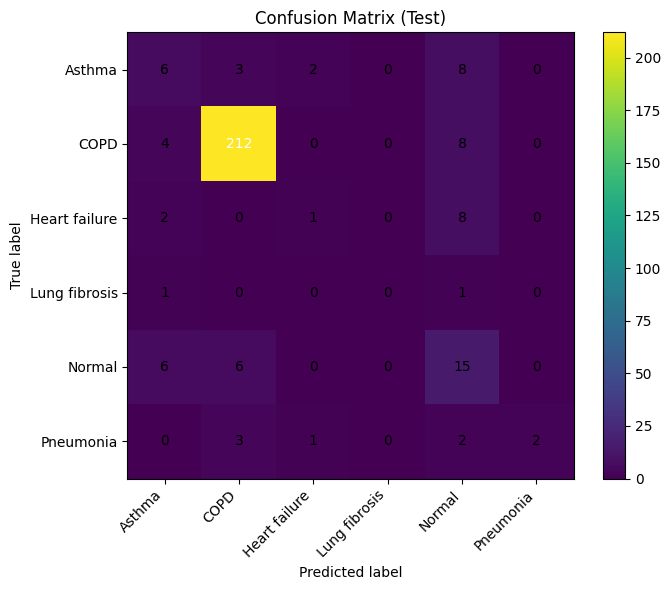

In [24]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=45, ha="right")
plt.yticks(tick_marks, LABELS)

# annotate
thresh = cm.max() * 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Top confusions (what the model mixes up)


In [25]:
# Build a confusion summary
confusions = []
for i, true_lbl in enumerate(LABELS):
    row = cm[i].copy()
    row[i] = 0
    j = int(row.argmax())
    confusions.append((true_lbl, LABELS[j], int(row[j]), int(cm[i].sum())))

conf_df = pd.DataFrame(confusions, columns=["true", "most_confused_as", "count", "support"])
conf_df["rate"] = conf_df["count"] / conf_df["support"].replace(0, np.nan)
conf_df = conf_df.sort_values("rate", ascending=False)
conf_df


,true,most_confused_as,count,support,rate
2,Heart failure,Normal,8,11,0.727273
3,Lung fibrosis,Asthma,1,2,0.500000
0,Asthma,Normal,8,19,0.421053
5,Pneumonia,COPD,3,8,0.375000
4,Normal,Asthma,6,27,0.222222
1,COPD,Normal,8,224,0.035714


## Show a few misclassified examples (file paths)

This helps you verify if:
- some labels are noisy,
- some recordings are very short / silent,
- cross-dataset mismatch (ICBHI vs Fraiwan).


In [26]:
# Collect misclassified rows
mis_idx = np.where(y_true != y_pred)[0]
mis = []
for k in mis_idx[:50]:  # first 50
    t = id_to_label[int(y_true[k])]
    p = id_to_label[int(y_pred[k])]
    prob = float(np.max(y_prob[k]))
    mis.append((t, p, prob, paths[k]))

mis_df = pd.DataFrame(mis, columns=["true", "pred", "pred_conf", "filepath"])
mis_df.head(20)


,true,pred,pred_conf,filepath
0,Asthma,COPD,0.259768,/teamspace/studios/this_studio/lung_sound_proj...
1,COPD,Asthma,0.290996,/teamspace/studios/this_studio/lung_sound_proj...
2,Asthma,Normal,0.315467,/teamspace/studios/this_studio/lung_sound_proj...
3,Heart failure,Normal,0.266146,/teamspace/studios/this_studio/lung_sound_proj...
4,Asthma,Normal,0.334154,/teamspace/studios/this_studio/lung_sound_proj...
5,Heart failure,Normal,0.292482,/teamspace/studios/this_studio/lung_sound_proj...
6,Normal,Asthma,0.309733,/teamspace/studios/this_studio/lung_sound_proj...
7,Heart failure,Asthma,0.329726,/teamspace/studios/this_studio/lung_sound_proj...
8,Pneumonia,Heart failure,0.279714,/teamspace/studios/this_studio/lung_sound_proj...
9,Normal,Asthma,0.312193,/teamspace/studios/this_studio/lung_sound_proj...


## Performance by dataset source (ICBHI vs Fraiwan)

We infer source from filepath string.


In [27]:
def infer_source(fp: str) -> str:
    s = fp.lower()
    if "/icbhi/" in s or "icbhi" in s:
        return "icbhi"
    if "/fraiwan/" in s or "fraiwan" in s:
        return "fraiwan"
    return "unknown"

src = np.array([infer_source(p) for p in paths])
for name in sorted(set(src.tolist())):
    mask = (src == name)
    if mask.sum() == 0:
        continue
    a = accuracy_score(y_true[mask], y_pred[mask])
    m = f1_score(y_true[mask], y_pred[mask], average="macro")
    w = f1_score(y_true[mask], y_pred[mask], average="weighted")
    print(f"{name:8s} | n={mask.sum():4d} | acc={a:.3f} | f1m={m:.3f} | f1w={w:.3f}")


fraiwan  | n=  62 | acc=0.339 | f1m=0.158 | f1w=0.297
icbhi    | n= 229 | acc=0.939 | f1m=0.427 | f1w=0.942


## Save metrics JSON (for your report)


In [28]:
metrics = {
    "test": {"acc": float(acc), "f1_macro": float(f1m), "f1_weighted": float(f1w)},
    "labels": LABELS,
    "confusion_matrix": cm.tolist(),
    "confusions": conf_df.to_dict(orient="records"),
}

out_json = REPORTS_DIR / "test_metrics.json"
out_json.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("Saved:", out_json)


Saved: /teamspace/studios/this_studio/lung_sound_project/reports/test_metrics.json


## Interpretation (use in your report)

- **Accuracy (0.8111)** looks good mainly because COPD dominates the test set (224/291).  
- **Macro-F1 (0.377)** is a fairer metric; it is dragged down by very small classes:
  - Heart failure: 11 samples  
  - Lung fibrosis: 2 samples (too small to learn & to evaluate)

To improve Macro-F1 (still keeping student-project scope):
1) **Collect more samples** for minority classes (especially Lung fibrosis, Heart failure).  
2) Try **Focal Loss** (gamma=2) OR **WeightedRandomSampler** (but then remove class weights).  
3) Consider a simpler baseline: **DenseNet + mean pooling** (no LSTM) and compare.  
4) Report two settings:
   - 4-class (ICBHI only) as strong baseline  
   - 6-class (ICBHI + Fraiwan) as extended experiment
